# Read dataset

In [74]:
# import libs
import numpy as np
import csv
import matplotlib.pyplot as plt
import scipy
import random
import pandas as pd
from collections import defaultdict

In [24]:
data = pd.read_csv('./all_data_merged.csv')

In [25]:
data.shape

(106804, 198)

In [26]:
# cut data to 100000
data = data[:100000]

In [27]:
data.shape

(100000, 198)

In [113]:
# shuffle
data.sample(frac=1)

In [114]:
# split training and testing set:
train = data[:70000]
test = data[70000:]

In [115]:
train.shape

(70000, 198)

In [116]:
test.shape

(30000, 198)

In [117]:
train.loc[0]['review_id']

'Q1sbwvVQXV2734tPgoKj4Q'

# Rating prediction: 
1. Baseline: Guessing with mean of total rating score
2. Latent factor model: 
3. Traditional classifier with feature collection
4. BOW & SVM based on review text
5. TextCnn based on review text  
Metric = MSE

In [118]:
# libs
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [248]:
# Training and testing labels
train_y = [d[1]['stars_x'] for d in train.iterrows()]
test_y = [d[1]['stars_x'] for d in test.iterrows()]
len(test_y)

30000

In [249]:
test_y[:5]

[5.0, 4.0, 4.0, 3.0, 5.0]

# Baseline: Predict with Global mean

In [121]:
list(data.columns)

['review_id',
 'user_id',
 'business_id',
 'stars_x',
 'useful_x',
 'funny_x',
 'cool_x',
 'text',
 'date',
 'name_x',
 'address',
 'city',
 'state',
 'postal_code',
 'latitude',
 'longitude',
 'stars_y',
 'review_count_x',
 'is_open',
 'attributes',
 'categories',
 'hours',
 'df_business',
 'Active Life',
 'Specialty Food',
 'Restaurants',
 'Food',
 'Chinese',
 'Ethnic Food',
 'Seafood',
 'Sushi Bars',
 'Japanese',
 'Financial Services',
 'Plumbing',
 'Shopping',
 'Local Services',
 'Home Services',
 'Home & Garden',
 'Printing Services',
 'Beauty & Spas',
 'Hair Salons',
 'Hair Stylists',
 'Barbers',
 'Cosmetics & Beauty Supply',
 'Nail Salons',
 'Day Spas',
 'Massage',
 'Professional Services',
 'IT Services & Computer Repair',
 'Breakfast & Brunch',
 'Mexican',
 'Fast Food',
 'Bars',
 'Nightlife',
 'Pubs',
 'Italian',
 'Pizza',
 'Chicken Wings',
 'Bakeries',
 'Fitness & Instruction',
 'Yoga',
 'Event Planning & Services',
 'Trainers',
 'Health & Medical',
 'Physical Therapy',
 'Gym

In [122]:
# mean of star rating in trainning set
ratingMean = sum([d[1]['stars_x'] for d in train.iterrows()]) / len(train)

In [123]:
ratingMean

3.7943142857142855

In [124]:
# predict with Mean
prediction = [ratingMean for d in test.iterrows()]
len(prediction)

30000

In [125]:
# Baseline MSE
mean_squared_error(test_y, prediction)

1.982708801632653

In [126]:
# Baseline MAE
mean_absolute_error(test_y, prediction)

1.1757524304761904

In [127]:
# test mean
testMean = sum([d[1]['stars_x'] for d in test.iterrows()]) / len(test)
testMean

3.7850333333333332

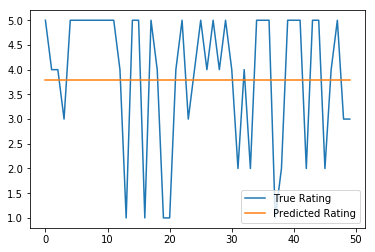

In [128]:
plt.plot(test_y[:50], label='True Rating')
plt.plot(prediction[:50], label='Predicted Rating')
plt.legend()

Baseline MSE: 1.9827   
Baseline MAE: 1.1757  
Seems like the average rating of test set is different from that in trainning set

# Latent factor model:  
Stronger Baseline in form of y_pred = alpha + gamma_u + gamma_res

In [129]:
# u, b, star rating pairs
ratingTrain = [(d[1]['user_id'], d[1]['business_id'], d[1]['stars_x']) for d in train.iterrows()]
ratingTest = [(d[1]['user_id'], d[1]['business_id'], d[1]['stars_x']) for d in test.iterrows()]

In [130]:
ratingTrain[:5]

[('5gz8szYeYntJMCBtReC8gA', 'Ws0_gbdmdFYaXHnhe-vXqQ', 4.0),
 ('ic-tyi1jElL_umxZVh8KNA', '9edPSkfXKsJmkZYIaOmA7Q', 4.0),
 ('VILrtjM6jV64r0QtvSMimg', 'PERCOYjFcIkwTaqOWz9G6w', 4.0),
 ('Gvmc0k5A7ALImXtkISOFcA', 'Y4vnA8okdRLoFOKSTWVd2g', 5.0),
 ('PuuP9Mzph7n3GsAcDr1TRQ', 'd8lmIZIqmBC9oPM8y1dc7Q', 5.0)]

In [131]:
# rating per user and rating per item (Based on Trainning set)
ratingPerUser = defaultdict(list)
ratingPerRes = defaultdict(list)
for d in train.iterrows():
    ratingPerUser[d[1]['user_id']].append((d[1]['business_id'], d[1]['stars_x']))
    ratingPerRes[d[1]['business_id']].append((d[1]['user_id'], d[1]['stars_x']))

In [132]:
ratingPerUser

defaultdict(list,
            {'5gz8szYeYntJMCBtReC8gA': [('Ws0_gbdmdFYaXHnhe-vXqQ', 4.0)],
             'ic-tyi1jElL_umxZVh8KNA': [('9edPSkfXKsJmkZYIaOmA7Q', 4.0),
              ('c-6ECG_qjX09UBOI1VrZyg', 4.0),
              ('OCmW3HWUDfO6yTsxq7Q9YQ', 5.0),
              ('Ke8t_l6CqoskQBtESsXwkw', 4.0),
              ('xbmxzInleHymSlaERwhMng', 1.0),
              ('BTtw9tkW4fw41L4s_PasrA', 4.0),
              ('NoT7u2QNEvsVbH9MIzAzlw', 5.0),
              ('ed3DtCasPymHqJ_0EKzmKg', 4.0),
              ('aO94Wsh2VzrgdCXu26OJEQ', 4.0)],
             'VILrtjM6jV64r0QtvSMimg': [('PERCOYjFcIkwTaqOWz9G6w', 4.0)],
             'Gvmc0k5A7ALImXtkISOFcA': [('Y4vnA8okdRLoFOKSTWVd2g', 5.0)],
             'PuuP9Mzph7n3GsAcDr1TRQ': [('d8lmIZIqmBC9oPM8y1dc7Q', 5.0)],
             'zaCd7fARVmxywzCT16Scjg': [('HhVmDybpU7L50Kb5A0jXTg', 3.0)],
             'WsaYftS0bxNPN2csfKaYyQ': [('-jdNqqzF1Dbve04oEd4jww', 4.0),
              ('WVAvGK24DQ9FdsEHBqIygQ', 4.0)],
             '8IO_tmmQPvdkI5ZXuxQAcQ': [(

In [133]:
# gradient decent
def iterate(lamb):
    newAlpha = 0
    for u,b,r in ratingTrain:
        newAlpha += r - (betaU[u] + betaI[b])
    alpha = newAlpha / len(ratingTrain)
    for u in ratingPerUser:
        newBetaU = 0
        for b,r in ratingPerUser[u]:
            newBetaU += r - (alpha + betaI[b])
        betaU[u] = newBetaU / (lamb + len(ratingPerUser[u]))
    for b in ratingPerRes:
        newBetaI = 0
        for u,r in ratingPerRes[b]:
            newBetaI += r - (alpha + betaU[u])
        betaI[b] = newBetaI / (lamb + len(ratingPerRes[b]))
    mse = 0
    for u,b,r in ratingTrain:
        prediction = alpha + betaU[u] + betaI[b]
        mse += (r - prediction)**2
    regularizer = 0
    for u in betaU:
        regularizer += betaU[u]**2
    for b in betaI:
        regularizer += betaI[b]**2
    mse /= len(ratingTrain)
    return mse, mse + lamb*regularizer

In [134]:
# user and business gamma
betaU = {}
betaI = {}
for u in ratingPerUser:
    betaU[u] = 0

for b in ratingPerRes:
    betaI[b] = 0
alpha = ratingMean

In [135]:
mse,objective = iterate(1)
newMSE,newObjective = iterate(1)
iterations = 2

In [136]:
# try until converge
while iterations < 10 or objective - newObjective > 0.0001:
    mse, objective = newMSE, newObjective
    newMSE, newObjective = iterate(1)
    iterations += 1
    print("Objective after "
        + str(iterations) + " iterations = " + str(newObjective))
    print("MSE after "
        + str(iterations) + " iterations = " + str(newMSE))

Objective after 3 iterations = 26040.40513496457
MSE after 3 iterations = 0.44952255261167307
Objective after 4 iterations = 25831.108604353747
MSE after 4 iterations = 0.4498881240592167
Objective after 5 iterations = 25777.87315116882
MSE after 5 iterations = 0.4500871474261881
Objective after 6 iterations = 25761.751098887187
MSE after 6 iterations = 0.4501772975190096
Objective after 7 iterations = 25755.638471365346
MSE after 7 iterations = 0.4502154678020815
Objective after 8 iterations = 25752.671116942893
MSE after 8 iterations = 0.4502306551828316
Objective after 9 iterations = 25750.881631059277
MSE after 9 iterations = 0.4502359613095881
Objective after 10 iterations = 25749.62323852654
MSE after 10 iterations = 0.45023711585692033
Objective after 11 iterations = 25748.65163551813
MSE after 11 iterations = 0.45023660365186374
Objective after 12 iterations = 25747.86125524813
MSE after 12 iterations = 0.45023549719211087
Objective after 13 iterations = 25747.199987945787
MSE 

In [137]:
validMSE = 0
prediction = []
for u,b,r in ratingTest:
    bu = 0
    bi = 0
    if u in betaU:
        bu = betaU[u]
    if b in betaI:
        bi = betaI[b]
    pred = alpha + bu + bi
    prediction.append(pred)
    validMSE += (r - pred)**2

validMSE /= len(ratingTest)
print("Validation MSE = " + str(validMSE))

Validation MSE = 1.725849071831656


In [138]:
mean_squared_error(test_y, prediction)

1.7258490718316708

In [139]:
mean_absolute_error(test_y, prediction)

1.0395157994988355

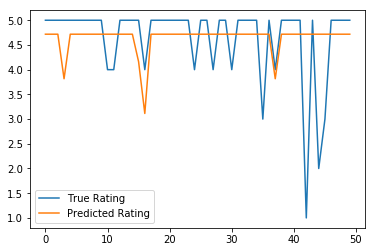

In [111]:
plt.plot(test_y[:50], label='True Rating')
plt.plot(prediction[:50], label='Predicted Rating')
plt.legend()

Latent Factor MSE: 1.7258  
Latent Factor MAE: 1.0395

# Linear Classifiers

In [140]:
import seaborn as sns

# BOW and SVM on review text

In [226]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [142]:
# stop words
stop_words = set(stopwords.words('english'))

In [146]:
# count
totalWords = 0
wordCount = defaultdict(int)
punct = string.punctuation
for l in train.iterrows():
    t = l[1]['text']
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    words = t.strip().split() # tokenizes
    for w in words:
        if w not in stop_words:
            totalWords += 1
            wordCount[w] += 1

In [147]:
# get the count tuple and find the most frequent 10
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [148]:
counts[:10]

[(38914, 'food'),
 (35475, 'good'),
 (34827, 'place'),
 (30950, 'great'),
 (25578, 'service'),
 (24258, 'like'),
 (23729, 'time'),
 (22436, 'get'),
 (22156, 'one'),
 (20549, 'back')]

In [190]:
x = 'abc123 as1241djc'
y = x.lower().split()
temp = []
for i in y:
    temp.append(''.join(k for k in i if not k.isdigit()))
' '.join(temp)

'abc asdjc'

In [202]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()
    temp = []
    for i in text:
        temp.append(''.join(k for k in i if not k.isdigit()))
    text = ' '.join(temp)
    
    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    # text = ' '.join(text)
#     text = ''.join(i for i in text if not i.isdigit())

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"there's", "there is ", text)
    text = re.sub(r"there're", "there are ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"\n", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [192]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [193]:
# clean text
def feature_clean(d):
    t = d
    t = t.lower() # lowercase string
    t = [c for c in t if not (c in punct)] # non-punct characters
    t = ''.join(t) # convert back to string
    return t

In [194]:
# train and test text data
train_text = [feature_clean(d[1]["text"]) for d in train.iterrows()]
test_text = [feature_clean(d[1]["text"]) for d in test.iterrows()]
train_text[:5]

['spoke with marie on the phone and she was very nice  she was patient and walked me through a number of questions i had regarding doing my own dyi flower arrangements  i did not feel rushed and she was able to make to understand a number of things about seasonal flowers and logistics for specific flowers  i will be communicating with marie via email for more details on my order for next month  im excited',
 'surprised the mall didnt suck\ngreat vans nike pac sun outlets \nhalls are narrow and mall poorly designed so it gets hectic and busy',
 'good ole fashioned irish pub good service beer and food their food specials are worthy big on soccer and other sports was a favorite during the world cup',
 'yummy yummy italian food hands down top three salad dressings in northeast ohio stop in and grab a salad and cheese try their lasagna you wont be disappointed',
 'i am a frequent visitor of pacos tacos my husband and i usually come here every sunday after church at 11 and are the first cust

In [203]:
# clean text
train_text_clean = []

for i in train_text:
    temp = replace_contractions(i)
    train_text_clean.append(text_to_wordlist(i))
train_text_clean[:5]

['spoke with marie on the phone and she was very nice she was patient and walked me through a number of questions i had regarding doing my own dyi flower arrangements i did not feel rushed and she was able to make to understand a number of things about seasonal flowers and logistics for specific flowers i will be communicating with marie via email for more details on my order for next month im excited',
 'surprised the mall didnt suck great vans nike pac sun outlets halls are narrow and mall poorly designed so it gets hectic and busy',
 'good ole fashioned irish pub good service beer and food their food specials are worthy big on soccer and other sports was a favorite during the world cup',
 'yummy yummy italian food hands down top three salad dressings in northeast ohio stop in and grab a salad and cheese try their lasagna you wont be disappointed',
 'i am a frequent visitor of pacos tacos my husband and i usually come here every sunday after church at and are the first customers to o

In [204]:
test_text_clean = []

for i in test_text:
    temp = replace_contractions(i)
    test_text_clean.append(text_to_wordlist(i))
test_text_clean[:5]

['a real guy place i know sportclips which i patronize also touts itself as a guys place but i feel more like a man after leaving downtown vintage barbershop ive been here twice now and with each of the barbers i can honestly say i feel confident no matter who i get good allaround solid haircut with attention to detail you can tell the young owner really cares about the place and wants to bring quality service to its patrons and is in it for the longhaul every time i pass by it seems there is always someone in the chair before this ownership it wasnt always the case the downtown vintage barbershop is a full service shop a straight razor is used during the final trim so a real clean finish is the result a single tv and mags adorn the place and some oldschool music is playing in the background dont forget cash as this place takes cold hard american dollars in the form of greenbacks only',
 'have been here a few times for dim sum this place is always full with customers during dim sumlunc

In [209]:
# remove stop words
stops = set(stopwords.words("english"))
train_x = []
for i in train_text_clean:
    text = i.lower().split()
    text = [w for w in text if not w in stops]
    train_x.append(' '.join(text))
train_x[:5]

['spoke marie phone nice patient walked number questions regarding dyi flower arrangements feel rushed able make understand number things seasonal flowers logistics specific flowers communicating marie via email details order next month im excited',
 'surprised mall didnt suck great vans nike pac sun outlets halls narrow mall poorly designed gets hectic busy',
 'good ole fashioned irish pub good service beer food food specials worthy big soccer sports favorite world cup',
 'yummy yummy italian food hands top three salad dressings northeast ohio stop grab salad cheese try lasagna wont disappointed',
 'frequent visitor pacos tacos husband usually come every sunday church first customers open doors food always amazing never one bad item service good enjoy music selection since come often one friends gave gift card birthday knows well next sunday put use find money put register gift card manager came let us know apologetic spoke friend regards amount card manager put amount card troubles q

In [221]:
# remove stop words
test_x = []
for i in test_text_clean:
    text = i.lower().split()
    text = [w for w in text if not w in stops]
    test_x.append(' '.join(text))
test_x[:5]

['real guy place know sportclips patronize also touts guys place feel like man leaving downtown vintage barbershop ive twice barbers honestly say feel confident matter get good allaround solid haircut attention detail tell young owner really cares place wants bring quality service patrons longhaul every time pass seems always someone chair ownership wasnt always case downtown vintage barbershop full service shop straight razor used final trim real clean finish result single tv mags adorn place oldschool music playing background dont forget cash place takes cold hard american dollars form greenbacks',
 'times dim sum place always full customers dim sumlunch hour dim sum discount price order placed food decent comes good pace dim sum service atmosphere overall experience good restaurant tip want come discount dim sum sure get table',
 'chipotle okay must say food prepared fresh daily ordered steak rice bowl white rice steak corn salsa yummy amount food little big eater ate whole thing al

In [211]:
seq_lens = [len(i) for i in train_x]

(array([  29.,  145.,  951., 3191., 3817., 3989., 3843., 3671., 3528.,
        3412., 3088., 2807., 2644., 2395., 2306., 2068., 1965., 1770.,
        1591., 1472., 1375., 1278., 1203., 1088.,  965.,  930.,  900.,
         807.,  773.,  763.,  679.,  657.,  525.,  515.,  503.,  512.,
         451.,  419.,  410.,  354.,  346.,  323.,  306.,  290.,  268.,
         271.,  226.,  254.,  193.,  216.]),
 array([  0.  ,  19.98,  39.96,  59.94,  79.92,  99.9 , 119.88, 139.86,
        159.84, 179.82, 199.8 , 219.78, 239.76, 259.74, 279.72, 299.7 ,
        319.68, 339.66, 359.64, 379.62, 399.6 , 419.58, 439.56, 459.54,
        479.52, 499.5 , 519.48, 539.46, 559.44, 579.42, 599.4 , 619.38,
        639.36, 659.34, 679.32, 699.3 , 719.28, 739.26, 759.24, 779.22,
        799.2 , 819.18, 839.16, 859.14, 879.12, 899.1 , 919.08, 939.06,
        959.04, 979.02, 999.  ]),
 <a list of 50 Patch objects>)

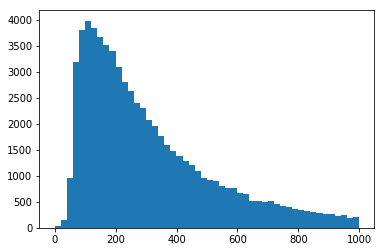

In [213]:
plt.hist([i for i in seq_lens if i < 1000], bins=50)

In [218]:
# count and tdidf
vectorizer = CountVectorizer()
train_x = vectorizer.fit_transform(train_x)
train_x

<70000x84573 sparse matrix of type '<class 'numpy.int64'>'
	with 3265085 stored elements in Compressed Sparse Row format>

In [222]:
test_x = vectorizer.transform(test_x)
test_x

<30000x84573 sparse matrix of type '<class 'numpy.int64'>'
	with 1374815 stored elements in Compressed Sparse Row format>

In [224]:
tfidf_transformer = TfidfTransformer()
train_x_trans = tfidf_transformer.fit_transform(train_x)
test_x_trans = tfidf_transformer.fit_transform(test_x)
train_x_trans

<70000x84573 sparse matrix of type '<class 'numpy.float64'>'
	with 3265085 stored elements in Compressed Sparse Row format>

# Logistic Regression

In [243]:
mod = LogisticRegression()
mod.fit(train_x_trans, train_y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [244]:
pred = mod.predict(test_x_trans)

In [245]:
print(mean_squared_error(pred, test_y))

0.8174333333333333


In [246]:
print(mean_absolute_error(pred, test_y))

0.4727


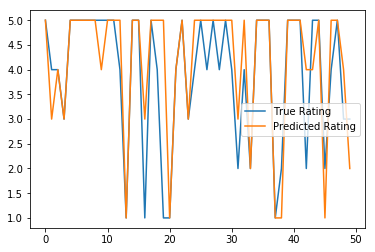

In [230]:
plt.plot(test_y[:50], label='True Rating')
plt.plot(pred[:50], label='Predicted Rating')
plt.legend()

# Linear SVM

In [234]:
clf = LinearSVC(C=0.8)
clf.fit(train_x_trans, train_y)

LinearSVC(C=0.8, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [235]:
pred = clf.predict(test_x_trans)
print(mean_squared_error(pred, test_y))

0.8220666666666666


# SGD classifier

In [236]:
sgd = SGDClassifier()
sgd.fit(train_x_trans, train_y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [237]:
pred = sgd.predict(test_x_trans)
print(mean_squared_error(pred, test_y))

0.9932333333333333


# XGB

In [238]:
# xgboost version
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(objective='reg:linear', colsample_bytree= 0.3, learning_rate=0.3, max_depth=10, alpha = 10, n_estimators = 50)

In [240]:
xgb_clf.fit(train_x_trans, train_y)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [241]:
pred = xgb_clf.predict(test_x_trans)
print(mean_squared_error(pred, test_y))

1.0977666666666666
